In [1]:
import numpy as np
from datetime import datetime as dt,timedelta
import xarray as xr
import netCDF4 as nc
import os
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from lib import driver
# from lib import plot 
# from lib.tools import get_categorical_obs, get_categorical_fcst, get_heidke, get_rpss
# from lib import verif
# from lib.tools import *
import pandas as pd
import xskillscore as xs

ERROR 1: PROJ: proj_create_from_database: Open of /home/ycheng/.conda/envs/cpc/share/proj failed


In [2]:
# year = 2019
# ds = xr.open_dataset(f'{SCORDIR}/{year}.nc')
VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_reforecast'
SCORDIR = f'{VERIFDIR}/verification'
years = np.arange(2017,2023,1)
ds1 = xr.open_mfdataset([f'{SCORDIR}/{year}.nc' for year in years], combine='nested',concat_dim='time')

In [3]:
VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_hindcast_fold_10'
SCORDIR = f'{VERIFDIR}/verification'
years = np.arange(2011,2017,1)
ds2 = xr.open_mfdataset([f'{SCORDIR}/{year}.nc' for year in years], combine='nested',concat_dim='time')


In [4]:
VERIFDIR = f'/Projects/jalbers_process/CPC_LIM/yuan_ming/CPC/Images_v2p0_hindcast_fold_9'
SCORDIR = f'{VERIFDIR}/verification'
years = np.arange(2005,2011,1)
ds3 = xr.open_mfdataset([f'{SCORDIR}/{year}.nc' for year in years], combine='nested',concat_dim='time')
ds = xr.concat([ds3, ds2, ds1], dim='time')
print(ds.time)

start_date = "2005-01-01"
end_date   = "2022-12-31"
date_range = pd.date_range(start=start_date, end=end_date)
print(len(date_range))

<xarray.DataArray 'time' (time: 6574)>
array(['2005-01-01T00:00:00.000000000', '2005-01-02T00:00:00.000000000',
       '2005-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2022-12-31
6574


In [5]:
observation = ds['observation']
probability = ds['probability']
observation_cold = observation[:,0,:]
probability_cold = probability[:,0,:]
observation_warm = observation[:,1,:]
probability_warm = probability[:,1,:]

In [6]:
probability_bins_label=np.array([0.0 , 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
probability_bins      =np.array([0.0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])


probability_categories_warm = np.digitize(probability_warm, probability_bins)
probability_categories_warm_flat = probability_categories_warm.flatten()
observation_warm_flat       = np.array(observation_warm).flatten()

# Calculate number of times 'True' in each probability bin
number_true_warm = np.bincount(probability_categories_warm_flat, weights=observation_warm_flat,minlength=probability_bins.shape[0])# minlength is set to return the count of all bins
number_forecast_warm = np.bincount(probability_categories_warm_flat,minlength=probability_bins.shape[0])
reliability_np_warm = number_true_warm/number_forecast_warm
# print('number of true:',number_true_warm)
# print('number of forecast:',number_forecast_warm)
# print('reliability',reliability_np_warm)

/tmp/ipykernel_1813418/3714483807.py:12: RuntimeWarning: invalid value encountered in divide
  reliability_np_warm = number_true_warm/number_forecast_warm


In [7]:
probability_categories_cold = np.digitize(probability_cold, probability_bins)
probability_categories_cold_flat = probability_categories_cold.flatten()
observation_cold_flat       = np.array(observation_cold).flatten()

# Calculate number of times 'True' in each probability bin
number_true_cold = np.bincount(probability_categories_cold_flat, weights=observation_cold_flat,minlength=probability_bins.shape[0])# minlength is set to return the count of all bins
number_forecast_cold = np.bincount(probability_categories_cold_flat,minlength=probability_bins.shape[0])
reliability_np_cold = number_true_cold/number_forecast_cold
# print('number of true cold:',number_true_cold)
# print('number of forecast cold:',number_forecast_cold)
# print('reliability',reliability_np_cold)

ds_reliability_np = xr.Dataset(
    {
        'reliability_warm':(['bin'],reliability_np_warm),
        'samples_warm':(['bin'],number_forecast_warm),
        'reliability_cold':(['bin'],reliability_np_cold),
        'samples_cold':(['bin'],number_forecast_cold),
        'diagnal':(['bin2'],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),

    },
    coords={
        'bin': probability_bins_label,
        'bin2':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
    }
)


/tmp/ipykernel_1813418/3009119480.py:8: RuntimeWarning: invalid value encountered in divide
  reliability_np_cold = number_true_cold/number_forecast_cold


In [8]:
reliability_xs = xs.reliability(observation_warm,probability_warm,probability_bin_edges=probability_bins)

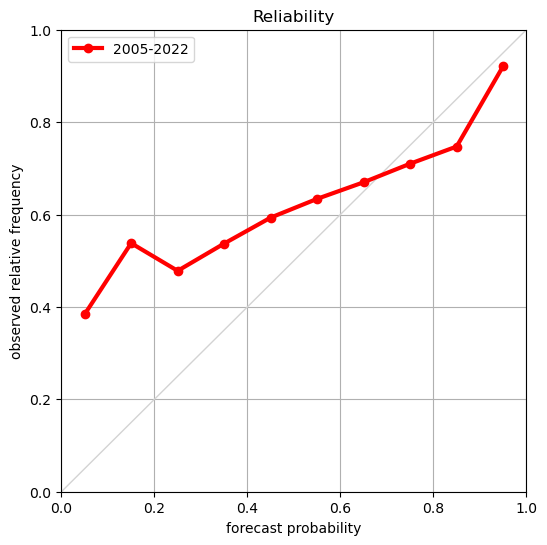

In [9]:
plt.figure(figsize=(6, 6))


reliability_warm = ds_reliability_np['reliability_warm']
reliability_cold = ds_reliability_np['reliability_cold']
diagnal = ds_reliability_np['diagnal']

diagnal.plot(linestyle='solid', color = 'lightgray',linewidth=1,xlim=(0,1),ylim=(0,1))

reliability_warm.plot(label='2005-2022', marker='o', linestyle='solid', color = 'red', linewidth=3,xlim=(0,1),ylim=(0,1))
# reliability_xs.plot(label='xskill', marker='o', linestyle='solid', color = 'blue', linewidth=3,xlim=(0,1),ylim=(0,1))
# reliability_cold.plot(label='cold', marker='o', linestyle='solid', color = 'blue',linewidth=3,xlim=(0,1),ylim=(0,1))

plt.xlabel('forecast probability')
plt.ylabel('observed relative frequency')
plt.title('Reliability')
plt.legend()
plt.grid(True)

In [10]:
observation_warm

<xarray.DataArray 'observation' (time: 6574, point: 282)>
dask.array<getitem, shape=(6574, 282), dtype=bool, chunksize=(366, 282), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2022-12-31
    event    int64 1
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 274 275 276 277 278 279 280 281

In [11]:
obs  = ds['observation'][:,1,:].where(ds['observation']['time.month']==1,drop=True)
obs

<xarray.DataArray 'observation' (time: 558, point: 282)>
dask.array<where, shape=(558, 282), dtype=float64, chunksize=(31, 282), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2022-01-31
    event    int64 1
  * point    (point) int64 0 1 2 3 4 5 6 7 8 ... 274 275 276 277 278 279 280 281

In [19]:
ds['observation']['time']

<xarray.DataArray 'time' (time: 6574)>
array(['2005-01-01T00:00:00.000000000', '2005-01-02T00:00:00.000000000',
       '2005-01-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2022-12-31

In [12]:
probability_bins_label=np.array([0.0 , 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
probability_bins      =np.array([0.0 , 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00])
# probability_bins        =np.array([0.0  , 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.00])
# probability_bins_label  =np.array([  0.025, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.975])

reliability_month = []
number_true_warm_month = []
number_forecast_warm_month = []
for mm in np.arange(1,13):
    obs  = ds['observation'][:,1,:].where(ds['observation']['time.month']==mm,drop=True)
    prob = ds['probability'][:,1,:].where(ds['probability']['time.month']==mm,drop=True)

    probability_categories_warm = np.digitize(prob, probability_bins)
    probability_categories_warm_flat = probability_categories_warm.flatten()
    observation_warm_flat       = np.array(obs).flatten()

    # Calculate number of times 'True' in each probability bin
    number_true_warm     = np.bincount(probability_categories_warm_flat, weights=observation_warm_flat,minlength=probability_bins.shape[0])# minlength is set to return the count of all bins
    number_forecast_warm = np.bincount(probability_categories_warm_flat, minlength=probability_bins.shape[0])
    reliability_warm  = number_true_warm/number_forecast_warm

    # reliability = xs.reliability(obs, prob, probability_bin_edges=probability_bins)
    reliability_month.append(reliability_warm)
    number_true_warm_month.append(number_true_warm)
    number_forecast_warm_month.append(number_forecast_warm)


/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered in divide
  reliability_warm  = number_true_warm/number_forecast_warm
/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered in divide
  reliability_warm  = number_true_warm/number_forecast_warm
/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered in divide
  reliability_warm  = number_true_warm/number_forecast_warm
/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered in divide
  reliability_warm  = number_true_warm/number_forecast_warm
/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered in divide
  reliability_warm  = number_true_warm/number_forecast_warm
/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered in divide
  reliability_warm  = number_true_warm/number_forecast_warm
/tmp/ipykernel_1813418/1193899979.py:20: RuntimeWarning: invalid value encountered

In [13]:
# np.array(number_forecast_warm_month).shape
# print(reliability_monthly)

In [15]:
# for i in np.arange(1,13):
#     # print(np.shape(reliability_month[i]).shape)    
#     print(np.shape(reliability_month[i]))

In [17]:
start_date = "2022-01-01"
end_date   = "2022-12-31"


ds_reliability_monthly = xr.Dataset(
    {
        'reliability_warm':(['month','bin'],np.array(reliability_month)),
        'number_true_warm':(['month','bin'],np.array(number_true_warm_month)),
        'number_forecast_warm':(['month','bin'],np.array(number_forecast_warm_month)),
        'diagnal':(['bin2'],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),

    },
    coords={
        'bin': probability_bins_label,
        'bin2':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
        'month': xr.cftime_range(start=start_date, end=end_date, freq="MS")
    }
)

# ds_reliability_monthly

<Figure size 600x600 with 0 Axes>

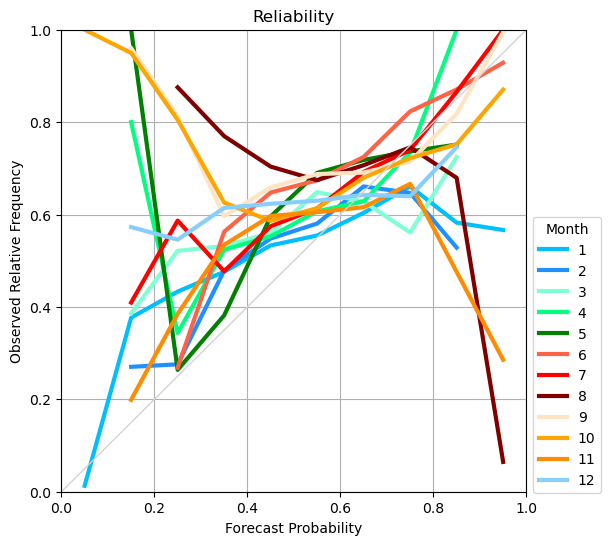

In [18]:
plt.figure(figsize=(6, 6))


# Extract the variable of interest
reliability_warm_monthly = ds_reliability_monthly['reliability_warm']

reliability_warm_monthly['month'] = reliability_warm_monthly['month.month']

month_colors = {1: 'deepskyblue', 2: 'dodgerblue', 3: 'aquamarine', 4: 'springgreen', 5: 'green', 6: 'tomato',
                7: 'red', 8: 'maroon', 9: 'bisque', 10: 'orange', 11: 'darkorange', 12: 'lightskyblue'}

# Create a single plot
plt.figure(figsize=(6, 6))

for month, color in month_colors.items():
    # Select data for the current month
    monthly_data = reliability_warm_monthly.where(reliability_warm_monthly['month'] == month, drop=True)
    # print('----------',month,'----------')
    # print(monthly_data)
    monthly_data.plot(label=month, linestyle='solid', color = color, linewidth=3,xlim=(0,1),ylim=(0,1))



# Add a diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='solid', color='lightgray', linewidth=1)


legend_x = .9  # Adjust as needed
legend_y = 0.58  # Adjust as needed
plt.legend(title='Month', loc='upper left', bbox_to_anchor=(legend_x, legend_y), bbox_transform=plt.gcf().transFigure)

# # Set plot limits
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.xlabel('Forecast Probability')
plt.ylabel('Observed Relative Frequency')
plt.title('Reliability')
plt.grid(True)
plt.show()



<Figure size 600x600 with 0 Axes>

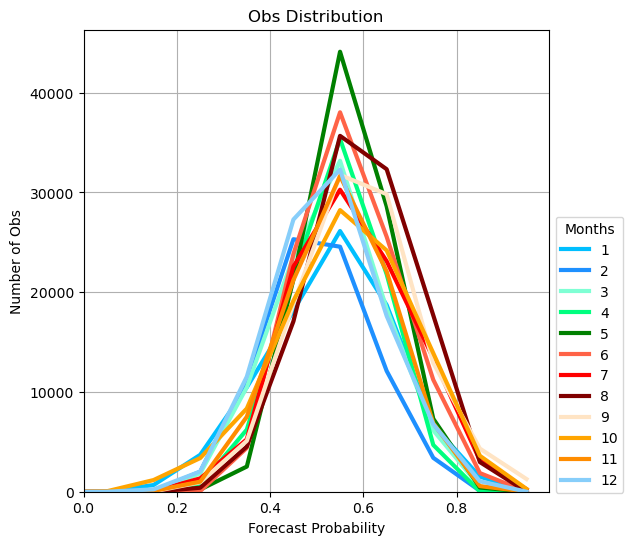

In [187]:
plt.figure(figsize=(6, 6))


# Extract the variable of interest
number_true_warm_monthly = ds_reliability_monthly['number_true_warm']

number_true_warm_monthly['month'] = number_true_warm_monthly['month.month']

month_colors = {1: 'deepskyblue', 2: 'dodgerblue', 3: 'aquamarine', 4: 'springgreen', 5: 'green', 6: 'tomato',
                7: 'red', 8: 'maroon', 9: 'bisque', 10: 'orange', 11: 'darkorange', 12: 'lightskyblue'}

# Create a single plot
plt.figure(figsize=(6, 6))

for month, color in month_colors.items():
    # Select data for the current month
    monthly_data = number_true_warm_monthly.where(number_true_warm_monthly['month'] == month, drop=True)
    # print('----------',month,'----------')
    # print(monthly_data)
    monthly_data.plot(label=month, linestyle='solid', color = color, linewidth=3)


legend_x = .9  # Adjust as needed
legend_y = 0.58  # Adjust as needed
plt.legend(title='Months', loc='upper left', bbox_to_anchor=(legend_x, legend_y), bbox_transform=plt.gcf().transFigure)

plt.xlim(0)
plt.ylim(0)

plt.xlabel('Forecast Probability')
plt.ylabel('Number of Obs')
plt.title('Obs Distribution')
plt.grid(True)
plt.show()


<Figure size 600x600 with 0 Axes>

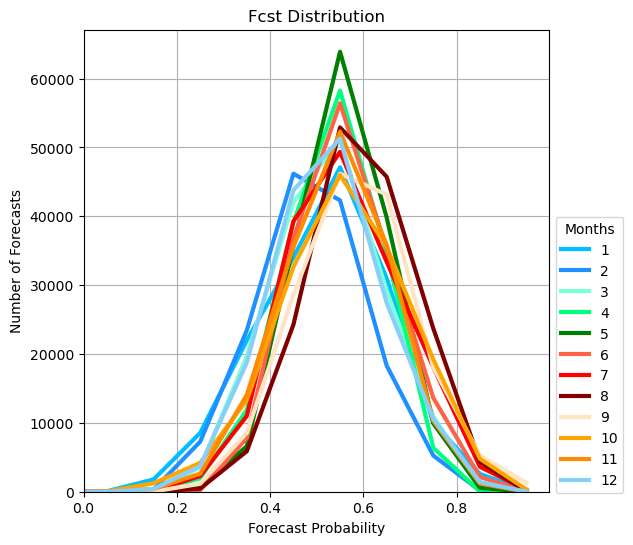

In [188]:
plt.figure(figsize=(6, 6))


# Extract the variable of interest
number_forecast_warm_monthly = ds_reliability_monthly['number_forecast_warm']

number_forecast_warm_monthly['month'] = number_forecast_warm_monthly['month.month']

month_colors = {1: 'deepskyblue', 2: 'dodgerblue', 3: 'aquamarine', 4: 'springgreen', 5: 'green', 6: 'tomato',
                7: 'red', 8: 'maroon', 9: 'bisque', 10: 'orange', 11: 'darkorange', 12: 'lightskyblue'}

# Create a single plot
plt.figure(figsize=(6, 6))

for month, color in month_colors.items():
    # Select data for the current month
    monthly_data = number_forecast_warm_monthly.where(number_forecast_warm_monthly['month'] == month, drop=True)
    # print('----------',month,'----------')
    # print(monthly_data)
    monthly_data.plot(label=month, linestyle='solid', color = color, linewidth=3)


legend_x = .9  # Adjust as needed
legend_y = 0.58  # Adjust as needed
plt.legend(title='Months', loc='upper left', bbox_to_anchor=(legend_x, legend_y), bbox_transform=plt.gcf().transFigure)
plt.xlim(0)
plt.ylim(0)

plt.xlabel('Forecast Probability')
plt.ylabel('Number of Forecasts')
plt.title('Fcst Distribution')
plt.grid(True)
plt.show()